<div style="margin: 0 auto 10px; height: 70px; border: 2px solid gray; border-radius: 6px;">
  <div style="float: left; margin: 5px 10px 5px 10px; "><img src="img/bfh.jpg" /></div>
  <div style="float: right; margin: 20px 30px 0; font-size: 15pt; font-weight: bold; color: #98b7d2;"><a href="https://moodle.bfh.ch/course/view.php?id=39255" style="color: #98b7d2;">BTE5476 - Project-Oriented Digital Signal Processing </a></div>
</div>
<div style="clear: both; font-size: 30pt; font-weight: bold; color: #64788b; margin-left: 30px;">
    BPSK
</div>

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp
import IPython
from scipy.io import wavfile
import random
import string

In [3]:
plt.rcParams["figure.figsize"] = (9,2.5)

The following functions were originally defined in the notebooks on biquad filters.

In [5]:
def LPF(fc, sf, Q=(1/np.sqrt(2))):
    """Biquad lowpass filter"""
    w = 2 * np.pi * fc / sf
    alpha = np.sin(w) / (2 * Q)
    c = np.cos(w)
    a = np.array([1 + alpha, -2 * c, 1 - alpha])
    b = np.array([(1 - c) / 2, 1 - c, (1 - c) / 2])
    return b / a[0], a / a[0]

In [6]:
Fs = 16000  # default sampling rate for the examples in the notebook

# Binary Phase Shift Keying

In our previous lecture we looked at how to use an instantaneous phase reversal in a sinusoidal carrier to transmit a synchronization pulse. In that case, a single phase reversal was used to convey timing information (e.g. a "start" signal); but, if we knew in advance when one or more phase reversals were going to happen, their presence or absence would correspond to one bit of information each. This is the idea behind BPSK communications.

## The BPSK signal

A BPSK trasnmitter encodes a binary stream by looking at a new incoming bit every $T_B$ seconds and reversing the phase of a sinusoidal carrier if the new bit is different than the previous one (this is called _differential encoding_).

 * $f_c$ is the frequency of the carrier
 * $B$ is the rate of the transmitter in bits per second (bps); $T_B = 1/B$ is called the _symbol interval_

Given a sequence of binary digits $b[n]$, an analog BPSK transmitter would output the signal

$$
    x(t) = 2\left(b\left[\, \lfloor t / B \rfloor \,\right] - 1/2\right)\,\cos(2\pi f_c t)
$$

<div style="margin: 50px 0 0 50px;"><img src="img/bpsk.png" width="600"></div>

## Syncrhonous BPSK

Usually, a BPSK transmitter is designed to be _synchronous_, that is we choose $f_c = PB$ with $P$ a positive integer; since $T_B = P(1/f_c)$, this means that **the symbol interval will span exactly an integer number of carrier periods.** This choice will simplify the implementation of the receiver, as we will see.

# The Data Link

The user data must first be converted to a binary stream suitable to BPSK trasmission and this is performed by a _data link layer_ module. Here we assume that the user data is a sequence of 8-bit bytes, typically a sequence of ASCII characters. The data link layer defines an _escape byte_ (or sync word), a special 8-bit value that will never appear in the data payload; the transmitted bistream is built as follows:

 * first, a synchronization burst of several sync words is sent
 * the user data is sent one bit at a time; if the sync word is going to appear in the sequence, a _stuffing bit_ is inserted to prevent it
 * periodically, a sync word is inserted to provide points of recovery in case of decoding errors.

The implementation here below is inspired by the [HDLC](https://en.wikipedia.org/wiki/High-Level_Data_Link_Control) standard, which is the data link layer for USB.

Note that, for reasons that will be apparent when we look at the receiver, in BPSK the bit stream is sent _differentially encoded_, that is, we send a 1 when there is a _transition_ in the bitstream (the current bit is different from the previous one) and a -1 otherwise. Differential encoding and decoding is easily performed via a XOR operation.

In [70]:
class DataLink:
    WAIT_SYNC, WAIT_START, DECODE, SKIP_1, SKIP_2 = 0, 1, 2, 3, 4
    
    def __init__(self):
        self.MAX_ONES, self.SYNC_WORD = 5, self.char2bits(chr(0b01111110))
        self.START_SYNCS = 5
        self.FRAME_SIZE = 10 # bytes
        self.last_bit = False
        self.reset()

    @classmethod
    def char2bits(cls, c):
        return np.array([ b == '1' for b in format(ord(c), '08b') ])
    
    @classmethod
    def bits2char(cls, b):
        return chr(np.uint8(b @ [128, 64, 32, 16, 8, 4, 2, 1]))
    
    def encode_message(self, text, repeat=1, preamble=0):
        self.count, self.ones = 0, 0
        ret = np.tile(self.SYNC_WORD, preamble) 
        
        for i in range(0, repeat):
            ret = np.r_[ ret, np.tile(self.SYNC_WORD, self.START_SYNCS + 1) ]
            for c in text:
                self.count += 1
                if self.count >= self.FRAME_SIZE:
                    ret = np.r_[ ret, self.SYNC_WORD ]
                    self.count, self.ones = 0, 0

                for b in self.char2bits(c):
                    ret = np.r_[ ret , b ]
                    self.ones = self.ones + 1 if b else 0
                    if self.ones == self.MAX_ONES:
                        ret = np.r_[ ret , False ]  # bit stuffing
                        self.ones = 0  

        # append a "wrong" sync word to stop the receiver
        ret = np.r_[ ret, self.SYNC_WORD, self.SYNC_WORD[:-1], True ]
        
        # differential encoding via XOR
        for n in range (1, len(ret)):
            ret[n] = ret[n] != ret[n-1]
        return ret

    def reset(self):
        self.count, self.ones, self.syncs = 0, 0, 0
        self.buf = np.full(8, False)
        self.state, self.resume = self.WAIT_SYNC, self.WAIT_START
        
    def decode_stream(self, bits, reset=False):        
        if reset:
            self.reset()
        
        ret = ''
        for bit in bits:
            # differential decoding via XOR
            b = self.last_bit != bit
            self.last_bit = bit
                
            if self.state == self.SKIP_1:
                # if we're here, either there's a stuffed bit or a new sync word
                self.state = self.SKIP_2 if b else self.DECODE
                continue
            elif self.state == self.SKIP_2:
                if b: # something's wrong, let's wait for the next start burst
                    self.reset()
                else:
                    self.count = 0
                    self.state = self.DECODE
                continue

            self.count += 1            
            self.buf = np.r_[ self.buf[1:], b ]
            self.ones = self.ones + 1 if b else 0
                
            if self.state == self.WAIT_SYNC:
                if np.equal(self.buf, self.SYNC_WORD).all():
                    self.count, self.ones, self.syncs = 0, 0, 0   
                    self.state = self.resume
                    
            elif self.state == self.WAIT_START:
                if self.count == 8:
                    self.count = 0
                    self.syncs = self.syncs + 1 if np.equal(self.buf, self.SYNC_WORD).all() else 0
                if self.syncs >= self.START_SYNCS:
                    self.count, self.ones, self.syncs = 0, 0, 0   
                    self.state = self.resume = self.DECODE  
                
            else: # decoding
                if self.count == 8:
                    ret += self.bits2char(self.buf)
                    self.count = 0
                if self.ones == self.MAX_ONES: 
                    # remove stuffed bit or skip sync word
                    self.ones = 0
                    self.state = self.SKIP_1
        return ret

In [72]:
msg = ''.join(chr(int(a)) for a in np.arange(48, 123)) + '\n'

dl = DataLink()
dec = dl.decode_stream(dl.encode_message(msg, repeat=10, preamble=5))
assert dec == msg * 10, "there's a bug!"

# Digital design

In a digital implementation of a synchronous BPSK transmitter (at a samping rate $F_s$) there are two constraints:

 * we want an integer number of samples per bit, that is, we want $F_s/B = K \in \mathbb{N}$; since the sampling rate is usually fixed, this will require adjusting the value of $B$ (which doesn't need to be an integer) by choosing a suitable $K$
 * we want the carrier to span an integer number of periods $P$ over a symbol interval, that is, $f_c = PB = (P/K)F_s$

The following class prototype adjusts the values of $B$ and $f_c$ as needed:

In [14]:
class BPSK:
    Fs = 16000
    CARRIER_HZ = 2000
    BPS = 50
    
    def __init__(self, fc=CARRIER_HZ, bps=BPS, sf=Fs):
        self.sf = sf
        print(f'target values at Fs={sf} Hz: {bps} bits per second, {fc} Hz carrier')
        # we want an integer number of samples per bit, so we adjust the other params accordingly
        self.spb = int(sf / bps)       # samples per bit (K)
        self.bps = sf / self.spb       # bits per second (B)
        self.ppb = int(fc / self.bps)  # carrier periods per bit (P)
        self.fc = self.ppb * self.bps  # adjusted carrier frequency
        print(f'  best match: {self.bps:.2f} bits per second ({self.spb} samples per bit), {self.fc:.2f} Hz carrier ({self.ppb} periods per bit)')
        self.wc = 2 * np.pi * self.fc / sf

If you want to change the default parameters you can:

In [16]:
bpsk_params = {
    'fc': 2000,
    'bps': 274,
    'sf': Fs
}

In [17]:
BPSK(**bpsk_params);

target values at Fs=16000 Hz: 274 bits per second, 2000 Hz carrier
  best match: 275.86 bits per second (58 samples per bit), 1931.03 Hz carrier (7 periods per bit)


# The transmitter

The following class will encode a string of ASCII characters into a BPSK signal of the form

$$
    x[n] = p[n]\cos(\omega_c n)
$$

where 

$$
    p[n] = \begin{cases}
        +1 & b[m] = 1 \\
        -1 & b[m] = 0 
        \end{cases} \qquad m = \lfloor n / K \rfloor
$$

and $b[m]$ is the stream of differentially-encoded bits generated by the data link layer from an input string of 8-bit characters.

In [19]:
class BPSK_TX(BPSK, DataLink):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        DataLink.__init__(self)

    def transmit(self, message, gap_len_ms=25, **kwargs):
        gap = np.zeros(int(self.sf / 1000 * gap_len_ms))
        bits = 2 * (self.encode_message(message, **kwargs) - 0.5)
        x = np.cos(self.wc * np.arange(0, len(bits) * self.spb)) * np.kron(bits, np.ones(self.spb))
        return np.r_[ gap, x, gap ], bits

In [20]:
tx = BPSK_TX(bps=200)
msg = 'Welcome to BTE5476. Today we will talk about BPSK.\n'
x, tx_bits = tx.transmit(msg, gap_len_ms=5.3, repeat=4)
print(f'{len(tx_bits)} bits sent')

target values at Fs=16000 Hz: 200 bits per second, 2000 Hz carrier
  best match: 200.00 bits per second (80 samples per bit), 2000.00 Hz carrier (10 periods per bit)
2000 bits sent


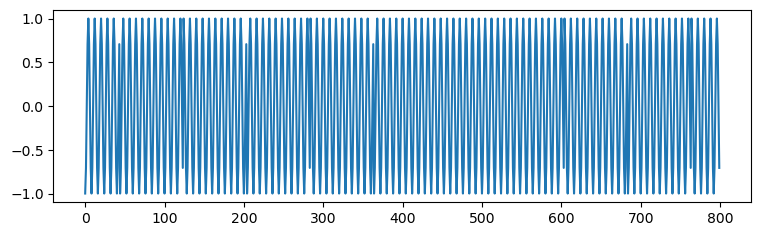

In [21]:
S = slice(200, 1000)
plt.plot(x[S]);

In [22]:
IPython.display.Audio(x, rate=tx.sf)

In [23]:
# uncomment this to save the audio file
#wavfile.write(f'afsk{int(tx.bps)}.wav', tx.sf, np.array(32760 * x, dtype=np.int16))

# The receiver

If we had an exact copy of the carrier at the receiver (with the right frequency and phase), we would stard by demodulating the passband signal as 

$$
  2x[n]\cos(\omega_c n) = 2p[n] \cos^2(\omega_c n) = p[n] + p[n]\cos(2\omega_c n)
$$

and then eliminate the component at $2\omega_c$ with a lowpass filter to obtain the baseband signal $\hat{p}[n]$. 

To recover the bitstream, if we know the exact time location of at least one of the phase reversals, call that $n_0$, we can simply check the sign of $\hat{p}[n]$ in the middle of every successive symbol interval, that is,

$$
    b[m] = \begin{cases}
        1 & \hat{p}[n_0 + \lfloor K/2 \rfloor + mK] \ge 0 \\
        0 & \mathrm{otherwise}
        \end{cases}.
$$


In a practical scenario we will thus need:

 * to recover the carrier from the input signal using a PLL
 * to recover the symbol timing from the basesband signal;

we will also need to pre-filter the received signal to eliminate the out the out-of-band additive noise and to adjust the input gain to make sure that the signal entering the demodulator has approximately unit amplitude.

## Carrier recovery

BPSK carrier recovery is greatly simplified by the fact that if we square the incoming signal we can easily remove the data-dependent part:

$$
    |x[n]|^2 = p^2[n]\cos^2(\omega_c n) = \cos^2(\omega_c n) = \frac{1}{2}\cos(2\omega_c n) + \frac{1}{2};
$$

this provides us with a "clean" sinusoid at twice the carrier frequency that we can track with a single PLL. Once we have locked on to the squared signal we can get both a local carrier replica and a sinusoid at the symbol frequency by dividing the NCO's phase by $2$ and by $2K$ respectively.

### A PLL with a frequency divider

In [27]:
class PLL_multi:
    def __init__(self, wc: float, phase_gain: float, freq_gain: float, K=1, sf=None):
        self.wc = 2 * np.pi * wc / sf if sf else wc
        self.pg, self.fg = phase_gain, freq_gain
        self.freq_offset = 0
        self.nco_phase, self.carrier_phase, self.symbol_phase = 0, 0, 0
        self.K= K

    @classmethod
    def phase_wrap(cls, w):
        return (w + np.pi) % (2 * np.pi) - np.pi

    def track(self, x: np.ndarray) -> np.ndarray:
        y = np.zeros((2, len(x)))
        for n in range(0, len(x)):
            y[:, n] = np.cos([self.carrier_phase, self.symbol_phase])
            phase_offset = -2 * (x[n] * x[n] - 0.5) * np.sin(self.nco_phase)
            self.freq_offset += self.fg * phase_offset
            c = self.pg * phase_offset + self.freq_offset
            self.nco_phase = self.phase_wrap(self.nco_phase + (self.wc + c)) 
            self.carrier_phase = self.phase_wrap(self.carrier_phase + (self.wc + c) / 2) 
            self.symbol_phase = self.phase_wrap(self.symbol_phase + (self.wc + c) / 2 / self.K) 
        return y

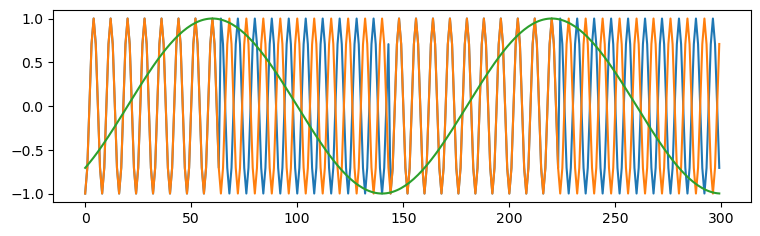

In [28]:
carrier, symbol = PLL_multi(2 * tx.wc, 0.01, 0.0005, K=tx.ppb * 2).track(x)

S = slice(100, 400)
plt.plot(x[S]);
plt.plot(carrier[S]);
plt.plot(symbol[S]);


## Demodulation and slicing

With the local carrier we can now demodulate via multiplication and lowpass filtering (we use a biquad here because a leaky integrator is not discriminative enough).
Looking at the baseband signal, we can see the sequence of positive and negative pulses; the problem is that we don't know yet where the midpoint of each symbol interval is:

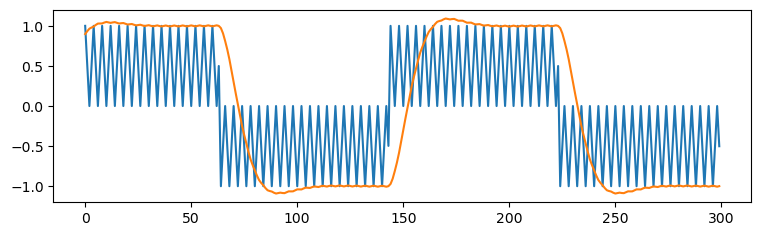

In [30]:
det = x * carrier
bb = 2 * sp.lfilter(*LPF(tx.bps * 2, tx.sf), det)

plt.plot(det[S]);
plt.plot(bb[S]);

## Timing recovery

In synchronous BPSK, the duration of a symbol interval is a multiple of the carrier period and so the PLL used for carrier recovery can provide also a timing reference for the symbol rate via frequency downconversion. However, since the PLL locks to a much higher frequency than the symbol rate, the phase of the downconverted reference can be aligned equally probably with any of the carrier periods within a symbol interval, as shown here. 

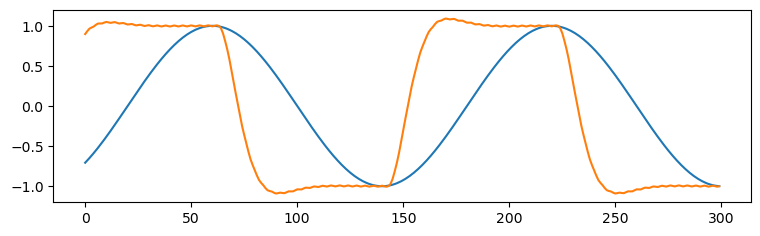

In [32]:
plt.plot(symbol[S]);
plt.plot(bb[S]);

What we would like instead is for the peaks of the symbol-rate sinusoid to fall right in the middle of each symbol interval and use those reference points to recover the bit values.

### Early-Late timing detector

Syncing to the phase of the baseband signal would appear to be a job for another PLL but in fact it's quite tricky to design PLLs for low frequenciss. Remember that in a PLL the loop filter is supposed to eliminate the error component at twice the input frequency from the slow-varying phase error estimate:

$$
    \hat\theta[n] = x[n]y[n] \propto \theta[n] + \sin(\varphi[n]+\alpha[n]);
$$

at low frequencies, we would need a loop filter with a very narrow passband and a sharp transition band, which mean that the loop filter would introduce a significant delay in the feedback path, which in turn makes it very difficult for the PLL to achieve a stable lock.

Instead of a PLL, therefore, we use an [_early-late_ timing recovery algorithm](https://wirelesspi.com/gardner-timing-error-detector-a-non-data-aided-version-of-zero-crossing-timing-error-detectors/): the error is estimated a a function of three consecutive baseband samples:

  * the current sample $\hat{p}[n]$
  * the _early_ sample $\hat{p}[n - \hat{K_n}/2]$
  * the _late_ sample $\hat{p}[n + \hat{K_n}/2]$

where $\hat{K_n}$ is the current estimate (at time $n$) of the number of bits per sample. The value of $\hat{K_n}$ is updated every $\hat{K_n}/2$ samples according to the value of the error and, in general, the algorithm converges very quickly to a value of $\hat{K}$ so that the samples at $n + m\hat{K}$ all fall in the middle of symbol periods.

In [35]:
def early_late(x, bps, sf, g=0.2):
    sync = np.full(len(x), 0.0)
    
    # nominal period in samples
    K, n = int(sf / bps / 2 + 0.5), 0
    while n < len(x) - K - 1:
        current, early, late = int(n + 0.5), int(n - K / 2 + 0.5), int(n + K / 2 + 0.5)
        ted = x[current] * (x[late] - x[early])
        n += K * (1 + ted * g)
        sync[current] = 1
    return sync

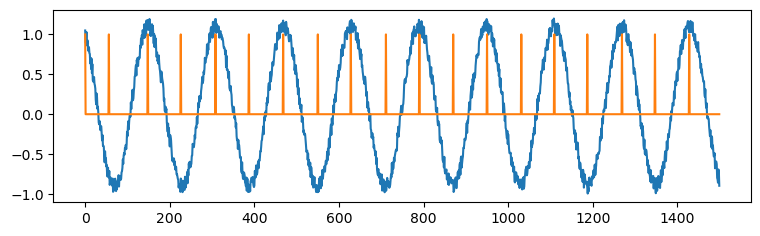

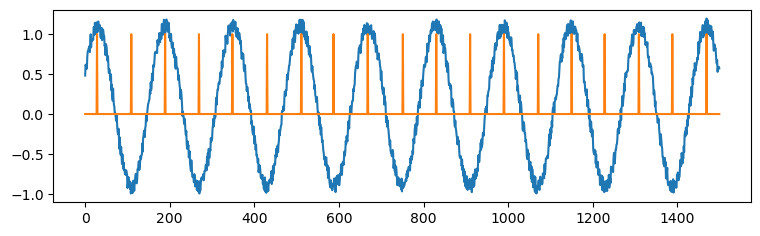

In [36]:
N = 5000

f = 100
test_signal = np.sin(2 * np.pi * f / Fs * np.arange(0, N) + 2) + np.random.rand(N) / 5

sync = early_late(test_signal, f, Fs)
for S in [slice(0, 1500), slice(-2000, -500)]:
    plt.figure()
    plt.plot(test_signal[S])
    plt.plot(sync[S])

We can try it on the demodulated baseband signal from before and it works quite well:

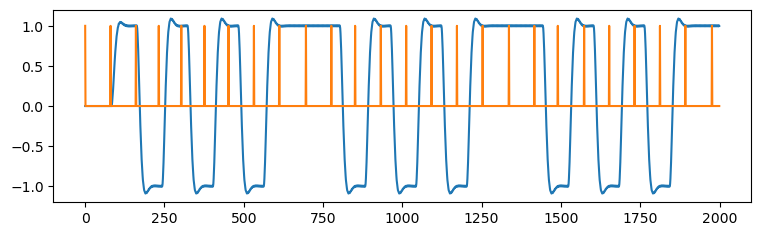

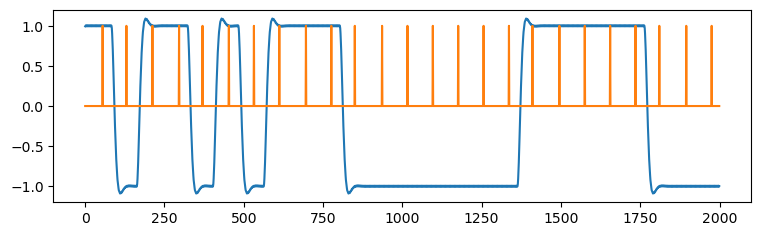

In [38]:
sync = early_late(bb, tx.bps / 2, tx.sf, g=0.05)
for S in [slice(0, 2000), slice(50000, 52000)]:
    plt.figure()
    plt.plot(bb[S])
    plt.plot(sync[S])

## Pre-filtering

The BPSK signal has a wide bandwidth but we can pre-filter the input with a bandpass centered at the carrier frequency and with a bandwidth of about six times the symbol rate to eliminate part of the additive noise introduced by the channel.

To get an intuition for the value of the filter's bandwidth, consider that each symbol, in magnitude, is a discrete-time rectangular pulse of length $K$ samples and its Fourier transform is thus:

$$
    P(e^{j\omega}) = \frac{\sin(K\omega/2)}{\sin\omega/2}.
$$

This spectral shape has spectral nulls at all multiples of $2\pi/K$ and so with a bandwidth of $6B$ we're capturing the main lobe plus two sidelobes.

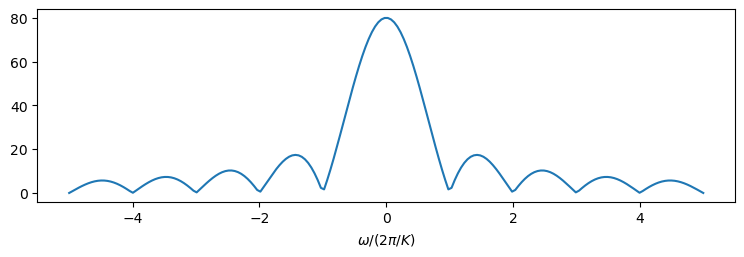

In [40]:
w = np.linspace(-np.pi/8 , np.pi/8, 200)
plt.plot(w / (2 * np.pi / tx.spb), np.abs(np.sin(tx.spb * w / 2) / np.sin(w / 2)));
plt.xlabel("$\\omega/(2\\pi/K)$");

## AGC

The AGC block is just like what we studied in the notebook on PLLs. The job here is easy because the incoming BPSK signal has a constant envelope. We set the target power level to $1/2$ so as to achieve unit amplitude for the modulated signal.

# Exercise: putting it all together

You now have all the elements to build your own BPSK receiver. You can test it on a synthetic signal first, generated by the transmitter, and later on a signal captured by the microphone of a laptop. If you are brave, you can try to implement the receiver in real time using the `portaudio` library: a code template is provided in the `rt` folder of this notebook.

## Audio test

In the `data` folder you will find four BPSK signals at 50, 100, 150 and 200 bps and carrier frequency 2 kHz; the signals have been played on a cell phone and captured on a laptop using its built-in microphone. How many can your receiver decode?

In [44]:
audio_samples = {}
for bps in [50, 100, 150, 200]:
    sf, audio = wavfile.read(f'data/capture{bps}.wav')
    audio_samples[bps] = audio / 32000.0